In [1]:
import anndata as ad
import scanpy as sc

import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import torch

from persist import PERSIST, ExpressionDataset, HurdleLoss

**Load and process dataset**

In [2]:
# see 00_data_proc.ipynb for details on how the .h5ad file was created
adata = ad.read_h5ad('../data/VISp_filtered_cells.h5ad')

# restrict to 10k highly variable genes
adata = adata[:,adata.var['highly_variable']].copy()

# save binarized data in a separate layer
adata.layers['bin'] = (adata.X>0).astype(np.float32)

print(adata)

AnnData object with n_obs × n_vars = 13349 × 10000
    obs: 'seq_name', 'class', 'subclass', 'cluster', 'cell_types_98', 'cell_types_50', 'cell_types_25'
    var: 'highly_variable'
    uns: 'hvg', 'log1p'
    layers: 'log1pcpm', 'bin'


**Create training and validation splits**

In [3]:
# Choose training and validation splits. 
# You may want to use a different strategy to choose these - see https://scikit-learn.org/stable/api/sklearn.model_selection.html
train_ind, val_ind = sk.model_selection.train_test_split(np.arange(adata.shape[0]), train_size=0.8)

print(f'{adata.shape[0]} total samples')
print(f'{np.size(train_ind)} in training set')
print(f'{np.size(val_ind)} in validation set')

# These are views, so they do not take up memory
adata_train = adata[train_ind,:]
adata_val = adata[val_ind,:]

13349 total samples
10679 in training set
2670 in validation set


**Run PERSIST**
 - Here the task is to select gene sets in an unsupervised manner. i.e. no cell types labels are used to obtain the gene set.
 - The objective is to choose a set of genes that can be used to reconstruct the remaining genes well.
 - We use PERSIST with a hurdle loss function, which is described in the manuscript. Briefly, this loss function accounts for zeros that might arise from dropout, and attempts to accurately reconstruct the log-normalized values.

In [4]:
# Initialize the dataset for PERSIST
# Note: Here, data_train.layers['bin'] is a sparse array
# data_train.layers['bin'].toarray() converts it to a dense array
train_dataset = ExpressionDataset(adata_train.layers['bin'], adata_train.layers['log1pcpm'])
val_dataset = ExpressionDataset(adata_val.layers['bin'], adata_val.layers['log1pcpm'])


# Use GPU device if available -- we highly recommend using a GPU!
device = torch.device(torch.cuda.current_device() if torch.cuda.is_available() else 'cpu')

# Number of genes to select within the current selection process.
num_genes_list = [32]
persist_results = {}

# Set up the PERSIST selector
selector = PERSIST(train_dataset,
                   val_dataset,
                   loss_fn=HurdleLoss(),
                   device=device)

# Coarse removal of genes
print('Starting initial elimination...')
candidates, model = selector.eliminate(target=500, max_nepochs=250)
print('Completed initial elimination.')

print('Selecting specific number of genes...')
for num in num_genes_list:
    inds, model = selector.select(num_genes=num, max_nepochs=250)
    persist_results[num] = inds
print('Done')

Starting initial elimination...
using HurdleLoss, starting with lam = 0.01


Training epochs:   0%|          | 0/250 [00:00<?, ?it/s]

lam = 0.010000 yielded 6733 genes
Warm starting model for next iteration
next attempt is lam = 0.100000


Training epochs:   0%|          | 0/250 [00:00<?, ?it/s]

lam = 0.100000 yielded 3063 genes
Warm starting model for next iteration
next attempt is lam = 0.884737


Training epochs:   0%|          | 0/250 [00:00<?, ?it/s]

lam = 0.884737 yielded 470 genes
done, lam = 0.884737 yielded 470 genes
Completed initial elimination.
Selecting specific number of genes...


Training epochs:   0%|          | 0/250 [00:00<?, ?it/s]

done, selected 32 genes
Done


In [5]:
# obtain a copy of features from the anndata object
# Note: Without the .copy(), you will modify adata itself, which may be desirable in some use cases.
df = adata.var.copy()

# set a boolean = True for genes selected in any of the rounds
for num in num_genes_list:
    df[f'persist_set_{num}'] = False
    ind = df.iloc[persist_results[num]].index
    df.loc[ind,f'persist_set_{num}'] = True

In [6]:
# only keep features (genes) that were selected in any set by PERSIST, and save for subsequent use
df = df[df[[f'persist_set_{num}' for num in num_genes_list]].any(axis=1)]

df.head(2)

,highly_variable,persist_set_32
genes,,
Ackr3,True,True
Adck3,True,True


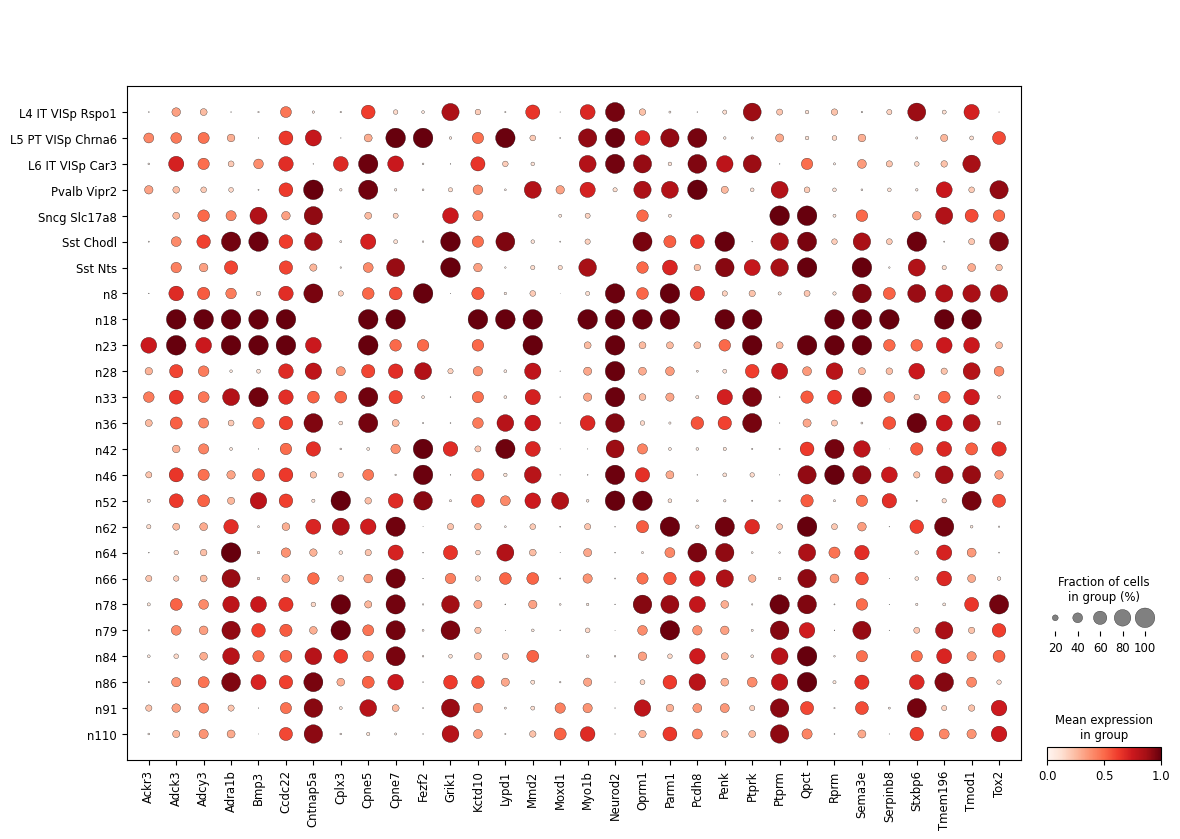

In [7]:
# Plot average binarized expression pattern for selection across cell types:
sc.pl.dotplot(adata,
              var_names=df[df['persist_set_32']].index.values,
              groupby='cell_types_25',
              layer='bin')
plt.show()